# Sesión 2

In [394]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')
#Paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabr
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcosrodrigo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [395]:
# Librerias
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling
!pip install vaderSentiment
!pip install seaborn
!pip install imbalanced-learn

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime


from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling

1. Perfilamiento, entendimiento de los datos y  análisis de la calidad de los datos

Carga de datos

In [396]:
data_cargada=pd.read_csv('Data/fake_news_spanish.csv', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
df=data_cargada

In [397]:
df.head(10)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,26/05/2019
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,16/09/2022
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,26/09/2019
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,25/02/2021
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,10/05/2021


In [398]:
df.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

Debemos de hacer una correccion de los datos
Titulo: string (se puede dejar como object, pero pandas tiene el tipo string que es más eficiente)
Descripcion: string (igual que el título)
Fecha: datetime64 (definitivamente no debería ser object)

In [399]:
# Convertir ID a numérico
# data['ID'] = pd.to_numeric(data['ID'])

# Convertir columnas de texto a string
df['Titulo'] = df['Titulo'].astype('string')
df['Descripcion'] = df['Descripcion'].astype('string')

# Convertir Fecha a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

In [400]:
df.dtypes

ID                     object
Label                   int64
Titulo         string[python]
Descripcion    string[python]
Fecha          datetime64[ns]
dtype: object

Inicializacion de herramientas

In [401]:
analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('spanish'))

# Entendimiento de los datos

# Limpieza de los datos

In [402]:
df.isnull().sum()


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [403]:
df[df.isna().any(axis=1)]

,ID,Label,Titulo,Descripcion,Fecha
3243,ID,0,<NA>,"Hace unos 75 años, Hermann Göring testificó en...",2019-06-16
4189,ID,0,<NA>,"Evidentemente, Barak Obama ha sido arrestado e...",2022-03-10
5041,ID,0,<NA>,"""Después de convertirme en presidente, le pedí...",2022-03-16
5644,ID,0,<NA>,Me pasaron de buena fuente hoy (un vecino del ...,2023-04-08
7345,ID,0,<NA>,Defienden dichos con capitulos de Don Gato. C...,2023-07-02
7652,ID,0,<NA>,Lean (y vean la imagen) con mucha atención: S...,2018-08-04
9700,ID,0,<NA>,¿Sabías que Francisco Sagasti salió a marchar ...,2018-12-26
15159,ID,0,<NA>,Declarar a Bill Gates enemigo público y proces...,2024-08-02
19415,ID,0,<NA>,Con el fin de captar votos están dispuestos a ...,2017-10-28
24806,ID,0,<NA>,CUANDO LAS IMÁGENES HABLAN MÁS QUE PALABRAS. ...,2018-06-28


In [404]:
df = df.dropna()
#Elimine los datos que no tienen titulo REVISAR

In [ ]:
palabras_sospechosas = set([
    'secreto', 'impactante', 'milagrosa', 'urgente', 'impresionante', 'sorprendente', 'insólito',
    'descubierto', 'alerta', 'indignante', 'peligroso', 'exclusivo', 'aterrador', 'impresionante',
    'conspiración', 'oculto', 'prohibido', 'mentira', 'falso', 'desmentido', 'engaño',
    'corrupción', 'censurado', 'revelación', 'encubierto', 'manipulación', 'trampa',
    'milagro', 'cura', 'prohibida', 'veneno', 'dañino', 'tóxico', 'ilegal', 'secreto',
    'remedio', 'increíble', 'fantástico', 'desconocido', 'nunca visto', 'no quieren que sepas',
    'última hora', 'no creerás', 'nadie lo esperaba', 'urgente', 'alerta máxima', 'devastador',
    'infalible', 'descubre', 'inexplicable', 'definitivo', 'drástico', 'imperdible', 'viral',
    'terror', 'amenaza', 'pánico', 'apocalipsis', 'devastador', 'tragedia', 'colapso',
    'desastre', 'crisis', 'fracaso', 'fin del mundo', 'poderoso', 'letal', 'brutal',
    'gana dinero', 'secreto bancario', 'hack', 'truco', 'fórmula mágica', 'sistema infalible',
    'multiplica tu dinero', 'solución definitiva', 'inversión garantizada', 'fácil y rápido',
    'químico peligroso', 'cura definitiva', 'anticancerígeno', 'natural y seguro', 'sin efectos secundarios',
    'poder de la mente', 'médicos lo odian', 'ciencia lo confirma', 'demostrado',
    'impresionante', 'alucinante', 'no lo podrás creer', 'revolucionario', 'radical', 'inigualable',
    'impactante', 'sorprendente', 'irrepetible', 'shock', 'devastador', 'asombroso'
])
# Palabras que nos pueden llegar a dirgir que un texto es falso

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalnum()]
    # return ' '.join(tokens)
    return (tokens)

def extraer_caracteristicas_texto(texto):
    if not isinstance(texto, str):
        return pd.Series([0, 0, 0, 0])  
    tokens = word_tokenize(texto.lower())
    num_palabras = len(tokens)
    num_sospechosas = sum(1 for palabra in tokens if palabra in palabras_sospechosas)
    sentimiento = analyzer.polarity_scores(texto)['compound']
    num_exclamaciones = texto.count('!') + texto.count('¡')
    return pd.Series([num_palabras, num_sospechosas, sentimiento, num_exclamaciones])


df['Título_procesado'] = df['Titulo'].apply(preprocess_text)
df['Descripción_procesado'] = df['Descripcion'].apply(preprocess_text)


# Crear columnas con las características
df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Título', 'Sentimiento_Título','Exclamaciones_Titulo']] = df['Titulo'].apply(
    lambda x: pd.Series(extraer_caracteristicas_texto(x))
)
df[['Numero_Palabras_Descripcion', 'Numero_Sospechosas_Descripcion','Sentimiento_Descripcion', 'Exclamaciones_Descripcion']] = df['Descripcion'].apply(
    lambda x: pd.Series(extraer_caracteristicas_texto(x))
)
# tools.display_dataframe_to_user(name="Análisis de Noticias", dataframe=df)

/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_15427/343441853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Título_procesado'] = df['Titulo'].apply(preprocess_text)
/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_15427/343441853.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Descripción_procesado'] = df['Descripcion'].apply(preprocess_text)
/var/folders/1j/z75cknhx76s2v56sd6b61_5w0000gn/T/ipykernel_15427/343441853.py:25: SettingWithCopyWarning: 
A value is trying

In [407]:
df.head(10)

,ID,Label,Titulo,Descripcion,Fecha,Título_procesado,Descripción_procesado,Numero_Palabras_Titulo,Numero_Sospechosas_Título,Sentimiento_Título,Exclamaciones_Titulo,Numero_Palabras_Descripcion,Numero_Sospechosas_Descripcion,Sentimiento_Descripcion,Exclamaciones_Descripcion
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,guardian va sánchez necesita apuesta dé frutos,diario británico publicó pasado jueves editori...,16.0,0.0,0.000,0.0,37.0,0.0,0.0000,0.0
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...,18.0,0.0,0.000,0.0,595.0,3.0,-0.8177,0.0
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,nunca joan fuster estatuto valenciano cumple 4...,valencianismo convoca castelló fiesta grande c...,15.0,0.0,0.000,0.0,32.0,0.0,0.4767,0.0
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,iglesias alienta yolanda díaz erc eh bildu neg...,política igual negociar empresarios negociar g...,20.0,0.0,0.000,0.0,23.0,0.0,0.3400,0.0
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,puigdemont ninguna tragedia repetición elecciones,entrevista punt avui líder jxcat desdramatizad...,12.0,1.0,0.000,0.0,47.0,0.0,0.3400,0.0
5,ID,1,"El PNV consolida su mayoría, el PSE salva los ...",Los nacionalistas consiguen las alcaldías de B...,2019-05-26,pnv consolida mayoría pse salva papeles pp sig...,nacionalistas consiguen alcaldías bilbao donos...,18.0,0.0,0.000,0.0,32.0,0.0,0.0000,0.0
6,ID,0,El exconsejero Núria Marín pide el indulto en ...,Sus familiares aluden a su honestidad e integr...,2022-09-16,exconsejero núria marín pide indulto caso ere ...,familiares aluden honestidad integridad person...,17.0,0.0,-0.296,0.0,19.0,0.0,0.0000,0.0
7,ID,1,La Fiscalía pide prisión incondicional para lo...,Suprime el delito de rebelión que les imputó i...,2019-09-26,fiscalía pide prisión incondicional siete cdr ...,suprime delito rebelión imputó inicialmente ma...,15.0,0.0,0.000,0.0,35.0,0.0,0.0000,0.0
8,ID,1,"José Manuel Pérez Tornero, el creador de la te...",El futuro presidente de RTVE es licenciado en ...,2021-02-25,josé manuel pérez tornero creador televisión e...,futuro presidente rtve licenciado ciencias com...,11.0,0.0,0.000,0.0,33.0,0.0,0.0000,0.0
9,ID,0,La 'Ayusización' del BNG: Santiago Abascal ins...,Pablo Santiago Abascal planea vivir de las ren...,2021-05-10,bng santiago abascal instruye seguir estela pr...,pablo santiago abascal planea vivir rentas arr...,20.0,0.0,0.000,0.0,43.0,0.0,-0.7003,0.0


# Regresion Logistica

Antes de eso probaremos si el set de datos esta balanceado

In [408]:
cantidadSi = (df["Label"] == 1).sum()
cantidadNo = (df["Label"] == 0).sum()
print(f"Noticias Verdaderas (1): {cantidadSi}")
print(f"Noticias Falsas (0): {cantidadNo}")

Noticias Verdaderas (1): 33158
Noticias Falsas (0): 23889


## VECTORIZAR EL TEXTO;
Cuando trabajamos con texto (como los títulos y descripciones de noticias), las computadoras no entienden palabras directamente; necesitan números. Vectorizar es el proceso de convertir texto en una representación numérica que un modelo de machine learning, como la regresión logística, pueda usar.

TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica específica para hacer esto. No solo cuenta palabras, sino que les da un "peso" según su importancia en el texto y en el conjunto de datos completo. Vamos por partes:

TF (Frecuencia del Término):
Mide cuántas veces aparece una palabra en un documento (en este caso, un título o descripción). Si "secreto" aparece 3 veces en un título corto, tiene una frecuencia alta.
IDF (Frecuencia Inversa del Documento):
Reduce el peso de palabras que aparecen en muchos documentos porque no son tan "especiales". Por ejemplo, si "el" aparece en casi todas las noticias, no ayuda a distinguir entre falsas y verdaderas, así que se le da menos importancia.
TF-IDF combinado:
Multiplica TF por IDF para darle más peso a palabras que son frecuentes en un documento, pero raras en el conjunto total. Así, palabras como "milagrosa" podrían destacar si aparecen en pocas noticias pero son clave en esas.

In [409]:
# tfidf_titulo = TfidfVectorizer(max_features=500)  
# tfidf_desc = TfidfVectorizer(max_features=500)
# X_titulo_tfidf = tfidf_titulo.fit_transform(df['Título_procesado']).toarray()
# X_desc_tfidf = tfidf_desc.fit_transform(df['Descripción_procesado']).toarray()

In [410]:
tfidf = TfidfVectorizer(max_features=500)  
X_tfidf = tfidf.fit_transform(df['Título_procesado'] + ' ' + df['Descripción_procesado']).toarray()
X_tfidf_df = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(X_tfidf.shape[1])])

Creo un DataFrame para las caracteristicas de vectorizacion

In [411]:
print(X_titulo_tfidf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [412]:
tfidf_titulo_cols = [f'tfidf_titulo_{i}' for i in range(X_titulo_tfidf.shape[1])]
tfidf_desc_cols = [f'tfidf_desc_{i}' for i in range(X_desc_tfidf.shape[1])]
X_titulo_df = pd.DataFrame(X_titulo_tfidf, columns=tfidf_titulo_cols)
X_desc_df = pd.DataFrame(X_desc_tfidf, columns=tfidf_desc_cols)

X = pd.concat([df[['Título_procesado', 'Numero_Palabras_Titulo', 'Sentimiento_Título', 'Exclamaciones_Titulo',
                   'Numero_Palabras_Descripcion', 'Sentimiento_Descripcion', 'Exclamaciones_Descripcion']],
               X_titulo_df, X_desc_df], axis=1)
y = df['Label']

In [413]:
X = df[['Numero_Palabras_Titulo', 'Numero_Sospechosas_Título', 'Sentimiento_Título','Numero_Palabras_Descripcion',
        'Numero_Sospechosas_Descripcion', 'Sentimiento_Descripcion']]
y = df['Label']

In [414]:
print("Tipos de datos en X:")
print(X.dtypes)

Tipos de datos en X:
Numero_Palabras_Titulo            float64
Numero_Sospechosas_Título         float64
Sentimiento_Título                float64
Numero_Palabras_Descripcion       float64
Numero_Sospechosas_Descripcion    float64
Sentimiento_Descripcion           float64
dtype: object


In [415]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [416]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [417]:
print(f"Después de SMOTE - Entrenamiento - Verdaderas: {(y_train_balanced == 1).sum()}")
print(f"Después de SMOTE - Entrenamiento - Falsas: {(y_train_balanced == 0).sum()}")

Después de SMOTE - Entrenamiento - Verdaderas: 24845
Después de SMOTE - Entrenamiento - Falsas: 24845


In [418]:
# cantidadSi =(X_train["Label"]==1).sum()
# cantidadNo =(y_train["Label"]==0).sum()

# print(cantidadSi,cantidadNo)
print(X_train.head( ))

       Numero_Palabras_Titulo  Numero_Sospechosas_Título  Sentimiento_Título  \
44361                    11.0                        0.0                 0.0   
55132                    22.0                        0.0                 0.0   
50409                    18.0                        0.0                 0.0   
35529                    16.0                        0.0                 0.0   
23831                    22.0                        0.0                 0.0   

       Numero_Palabras_Descripcion  Numero_Sospechosas_Descripcion  \
44361                         43.0                             0.0   
55132                         57.0                             0.0   
50409                         40.0                             0.0   
35529                         25.0                             0.0   
23831                         85.0                             0.0   

       Sentimiento_Descripcion  
44361                   0.0000  
55132                   0.4019  

In [419]:
modelo = LogisticRegression(max_iter=1000, class_weight='balanced')
modelo.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [420]:
y_pred = modelo.predict(X_test)


Evalucacion del modelo 

In [421]:
precision = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo: {precision * 100:.2f}%")


Precisión del modelo: 54.36%


In [422]:
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Falsa', 'Verdadera']))


Reporte completo:
              precision    recall  f1-score   support

       Falsa       0.46      0.53      0.49      5949
   Verdadera       0.62      0.55      0.58      8313

    accuracy                           0.54     14262
   macro avg       0.54      0.54      0.54     14262
weighted avg       0.55      0.54      0.55     14262



In [423]:
print("\nPesos de las características:")
for feature, coef in zip(X.columns, modelo.coef_[0]):
    print(f"{feature}: {coef:.4f}")


Pesos de las características:
Numero_Palabras_Titulo: -0.0372
Numero_Sospechosas_Título: -0.2221
Sentimiento_Título: 0.0291
Numero_Palabras_Descripcion: -0.0002
Numero_Sospechosas_Descripcion: -0.1711
Sentimiento_Descripcion: -0.0585


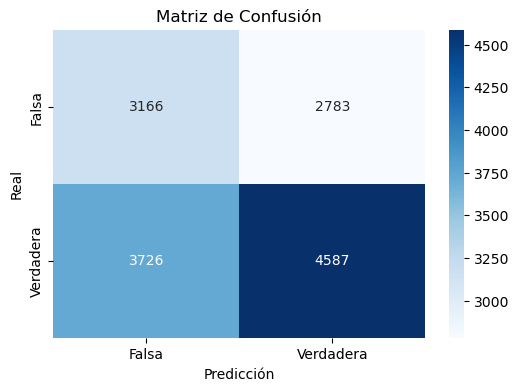

In [424]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Falsa', 'Verdadera'], yticklabels=['Falsa', 'Verdadera'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [425]:
print("\nPesos de las características numéricas:")
for feature, coef in zip(X.columns[:7], modelo.coef_[0][:7]):  # Limitado a las primeras 7 (no TF-IDF)
    print(f"{feature}: {coef:.4f}")


Pesos de las características numéricas:
Numero_Palabras_Titulo: -0.0372
Numero_Sospechosas_Título: -0.2221
Sentimiento_Título: 0.0291
Numero_Palabras_Descripcion: -0.0002
Numero_Sospechosas_Descripcion: -0.1711
Sentimiento_Descripcion: -0.0585
